# Simulation time!
### Grouped Patterns of Heterogeneity in Panel Data, Bonhomme, S. and Manresa, E. (2015)

In [1]:
# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

np.random.seed(seed=5) # used in random group assignment

nt = 20 # number of periods
nc = 10 # number of units
ng = 3  # number of groups

os.chdir(r"GFE_generic")

In [2]:
gtrend = np.random.randint(-10,10,ng)

gtresh = np.linspace(0,1,ng+1)[:-1]
group_place = np.random.random(nc) # assign uniform RN to each cross section
cg = [np.argmin(i>gtresh)+1 for i in group_place] # where the assigned RN are located in grid of thresholds

print(f'Thresholds for group assignment: {gtresh}')
print(f'Trends for each group: {gtrend}')
print(f'Assigned groups: {cg}')

Thresholds for group assignment: [0.         0.33333333 0.66666667]
Trends for each group: [-7  4  5]
Assigned groups: [1, 3, 1, 2, 3, 3, 3, 1, 1, 3]


# Creating trends

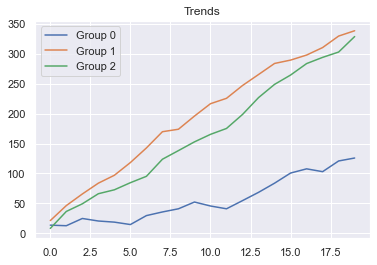

In [3]:
# Trends for groups
groups = {}
for i in range(ng):
    ds = [0]
    for y in range(nt):
        ds.append(ds[-1]+gtrend[i]+np.random.rand()*25) # drift
        
    groups['g'+str(i+1)+'t'] = ds[1:] # group i's trend
    plt.plot(groups['g'+str(i+1)+'t'], label='Group ' + str(i))

plt.title('Trends')
plt.legend()


# Create panel data based on groups, group trends, covariates and noise

In [4]:
Group_trend = []
time = []
individual = []
i_group = []
coef_X1 = 15
coef_X2 = 5
std_u = 10

for i, group in enumerate(cg):
    obs = groups['g'+str(group)+'t']
    Group_trend.extend(obs)
    time.extend(np.arange(nt))
    individual.extend(np.full(nt,i))
    i_group.extend(np.full(nt,group))
    
df               = pd.DataFrame()
df['X1']         = np.random.rand(len(Group_trend))
df['X2']         = np.random.rand(len(Group_trend))
df['Group_trend']= Group_trend
df['u']          = std_u*np.random.randn(len(Group_trend))
df['Y']          = df['Group_trend'] + coef_X1*df['X1']  + coef_X2*df['X2'] + df['u']
df['time']       = time
df['individual'] = individual
df['group']      = i_group

In [5]:
df

,X1,X2,Group_trend,u,Y,time,individual,group
0,0.845055,0.752940,13.486820,-0.146943,29.780407,0,0,1
1,0.643682,0.961268,12.550330,15.165287,42.177190,1,0,1
2,0.134241,0.329443,24.659645,2.747575,31.068047,2,0,1
3,0.176722,0.453632,20.432164,4.385131,29.736292,3,0,1
4,0.318868,0.364137,18.536033,9.949923,35.089661,4,0,1
...,...,...,...,...,...,...,...,...
195,0.776037,0.930707,264.462185,0.027304,280.783582,15,9,3
196,0.232709,0.863346,283.620969,-4.894016,286.534324,16,9,3
197,0.188396,0.019890,293.995450,-5.706661,291.214181,17,9,3
198,0.960805,0.752084,302.921228,1.307230,322.400956,18,9,3


([<matplotlib.axis.XTick at 0x1d6bc47ae20>,
 [Text(0, 0, ''), Text(0, 0, '')])

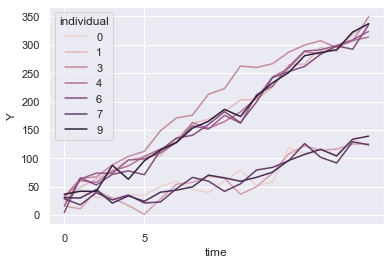

In [6]:
# Visualize by individuals
sns.lineplot(data=df,x='time',y='Y',hue='individual')
plt.xticks(np.arange(0, nc, step=5))

([<matplotlib.axis.XTick at 0x1d6bc557ac0>,
 [Text(0, 0, ''), Text(0, 0, '')])

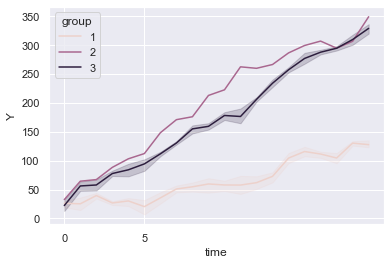

In [7]:
# Visualize by groups
sns.lineplot(data=df,x='time',y='Y',hue='group')
plt.xticks(np.arange(0, nc, step=5))

# Export to STATA to process it with the author's toolbox

In [8]:
df.to_stata(r'df.dta')

# Running authors' the toolbox

* Put data file (df.dta in our case), Bootstrap_version.exe and GFE_code.do files in the same directory. 
* Configure GFE_code.do. Adjust USER INPUTS. 
* Then run GFE_code, also fill in the prompted inputs.
* DATA_GFE.dta will be generated in the same folder. This data file contains group information. 


When running GFE_code.do, choose the following parameters:

* Adjust the data directory path in line 87.
* Number of groups: type “4” if number of groups is 4. 
* Number of covariates: type “2” if number of covariates is 2.
* Algorithm: type “1” (for Algorithm 2).
* Number of simulations: type “10”.
* Number of neighbors: type “10”
* Number of steps: type “10”.
* Standard errors: type “1” (for bootstrapped standard errors).
* Algorithm: type “1” (for Algorithm 2).
* Number of simulations: type “5”.
* Number of neighbors: type “10”.
* Number of steps: type “5”.
* Number of bootstrap replications: type “100”.

# Results

In [9]:
# Estimated groups
df_gfe = pd.read_stata(r'DATA_GFE.dta')
df_gfe.groupby('individual').agg({'assignment':['mean','max','min']})


assignment        
                 mean max min
individual                   
0                   1   1   1
1                   3   3   3
2                   1   1   1
3                   2   2   2
4                   3   3   3
5                   3   3   3
6                   3   3   3
7                   1   1   1
8                   1   1   1
9                   3   3   3

In [10]:
print('Assigned groups: {}'.format(cg))

est_g = df_gfe.groupby('individual')['assignment'].agg('mean').to_list()
print('Estimated groups: {}'.format(est_g))

Assigned groups: [1, 3, 1, 2, 3, 3, 3, 1, 1, 3]
Estimated groups: [1, 3, 1, 2, 3, 3, 3, 1, 1, 3]


# The end of simulation